# Replication - Schematic Figure

Here we provide a notebook to replicate the likelihood approximation figure.

The notebook replicates the results in:
- /out/simulation/figures/likelihood_approximation.eps

The main script can be found at: 
- /scripts/simulation/loglikelihood_training.py



In [3]:
!pip3 install probcox 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 5.0MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-cp37-none-any.whl size=5226 sha256=0a3ab5f4be9452b1ad309828f04e913965dc6c7004affa350e056439561554ca
  Stored in directory: /root/.cache/pip/wheels/7a/ed/e5/71cb95c54c96702f1412114114806c74394f421b6cbda6af70
Successfully built probcox


In [4]:
# Modules
# =======================================================================================================================

import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(5256)
torch.manual_seed(9235)


In [5]:
# Simulation Settings
# =======================================================================================================================
P_binary=3
P_continuous=3
P = P_binary + P_continuous
theta = np.random.uniform(-1.5, 1.5, (P, 1))
scale=0.75
I = 1000 # individuals
batchsize = 1024
iter_ = 5000
eta = 0.01


In [6]:
# Plot Settings
# =======================================================================================================================

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


In [7]:
# Simulation Data
# =======================================================================================================================
TVC = pcox.TVC(theta=theta, P_binary=P_continuous, P_continuous=P_continuous, dtype=dtype)
TVC.make_lambda0(scale=scale)
surv = torch.zeros((0, 3))
X = torch.zeros((0, 6))
for __ in (range(I)):
    a, b = TVC.sample()
    surv = torch.cat((surv, a))
    X = torch.cat((X, b))
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion = [total_obs, batchsize, total_events, None]


In [8]:
# Inference
# =======================================================================================================================
pyro.clear_param_store()
m = pcox.PCox(sampling_proportion=sampling_proportion)
m.initialize(eta=eta)
loss=[0]
LL_full = []
LL_batch = []
for ii in tqdm.tqdm(range((iter_))):
    idx = np.unique(np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 2, replace=False), np.random.choice(range(surv.shape[0]), batchsize-2, replace=False))))
    data=[surv[idx], X[idx]]
    if torch.sum(surv[idx][:, -1]) > 0:
        loss.append(m.infer(data=data))
    if loss[-1] != loss[-1]:
        eta = eta * 0.5
        run=True
        break
    g = m.return_guide()
    out = g.quantiles([0.5])
    theta_est = out['theta'][0].detach()
    with torch.no_grad():
        pred = torch.mm(X, theta_est).type(dtype)
        LL_full.append(pcox.CoxPartialLikelihood(pred=pred, sampling_proportion=None).log_prob(surv=surv).detach().numpy())
        LL_batch.append(pcox.CoxPartialLikelihood(pred=pred[idx], sampling_proportion=[total_obs, batchsize, total_events, torch.sum(surv[idx, -1]).numpy().tolist()]).log_prob(surv=surv[idx]).detach().numpy())

m_est = pcox.CoxPartialLikelihood(pred=pred, sampling_proportion=None).log_prob(surv=surv).detach().numpy()
m_approx = []
for _ in tqdm.tqdm(range(10000)):
    idx = np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 2, replace=False), np.random.choice(range(surv.shape[0]), batchsize-2, replace=False)))
    m_approx.append(pcox.CoxPartialLikelihood(pred=pred[idx], sampling_proportion=[total_obs, batchsize, total_events, torch.sum(surv[idx, -1])]).log_prob(surv=surv[idx]).detach().numpy())


100%|██████████| 10000/10000 [00:25<00:00, 388.19it/s]


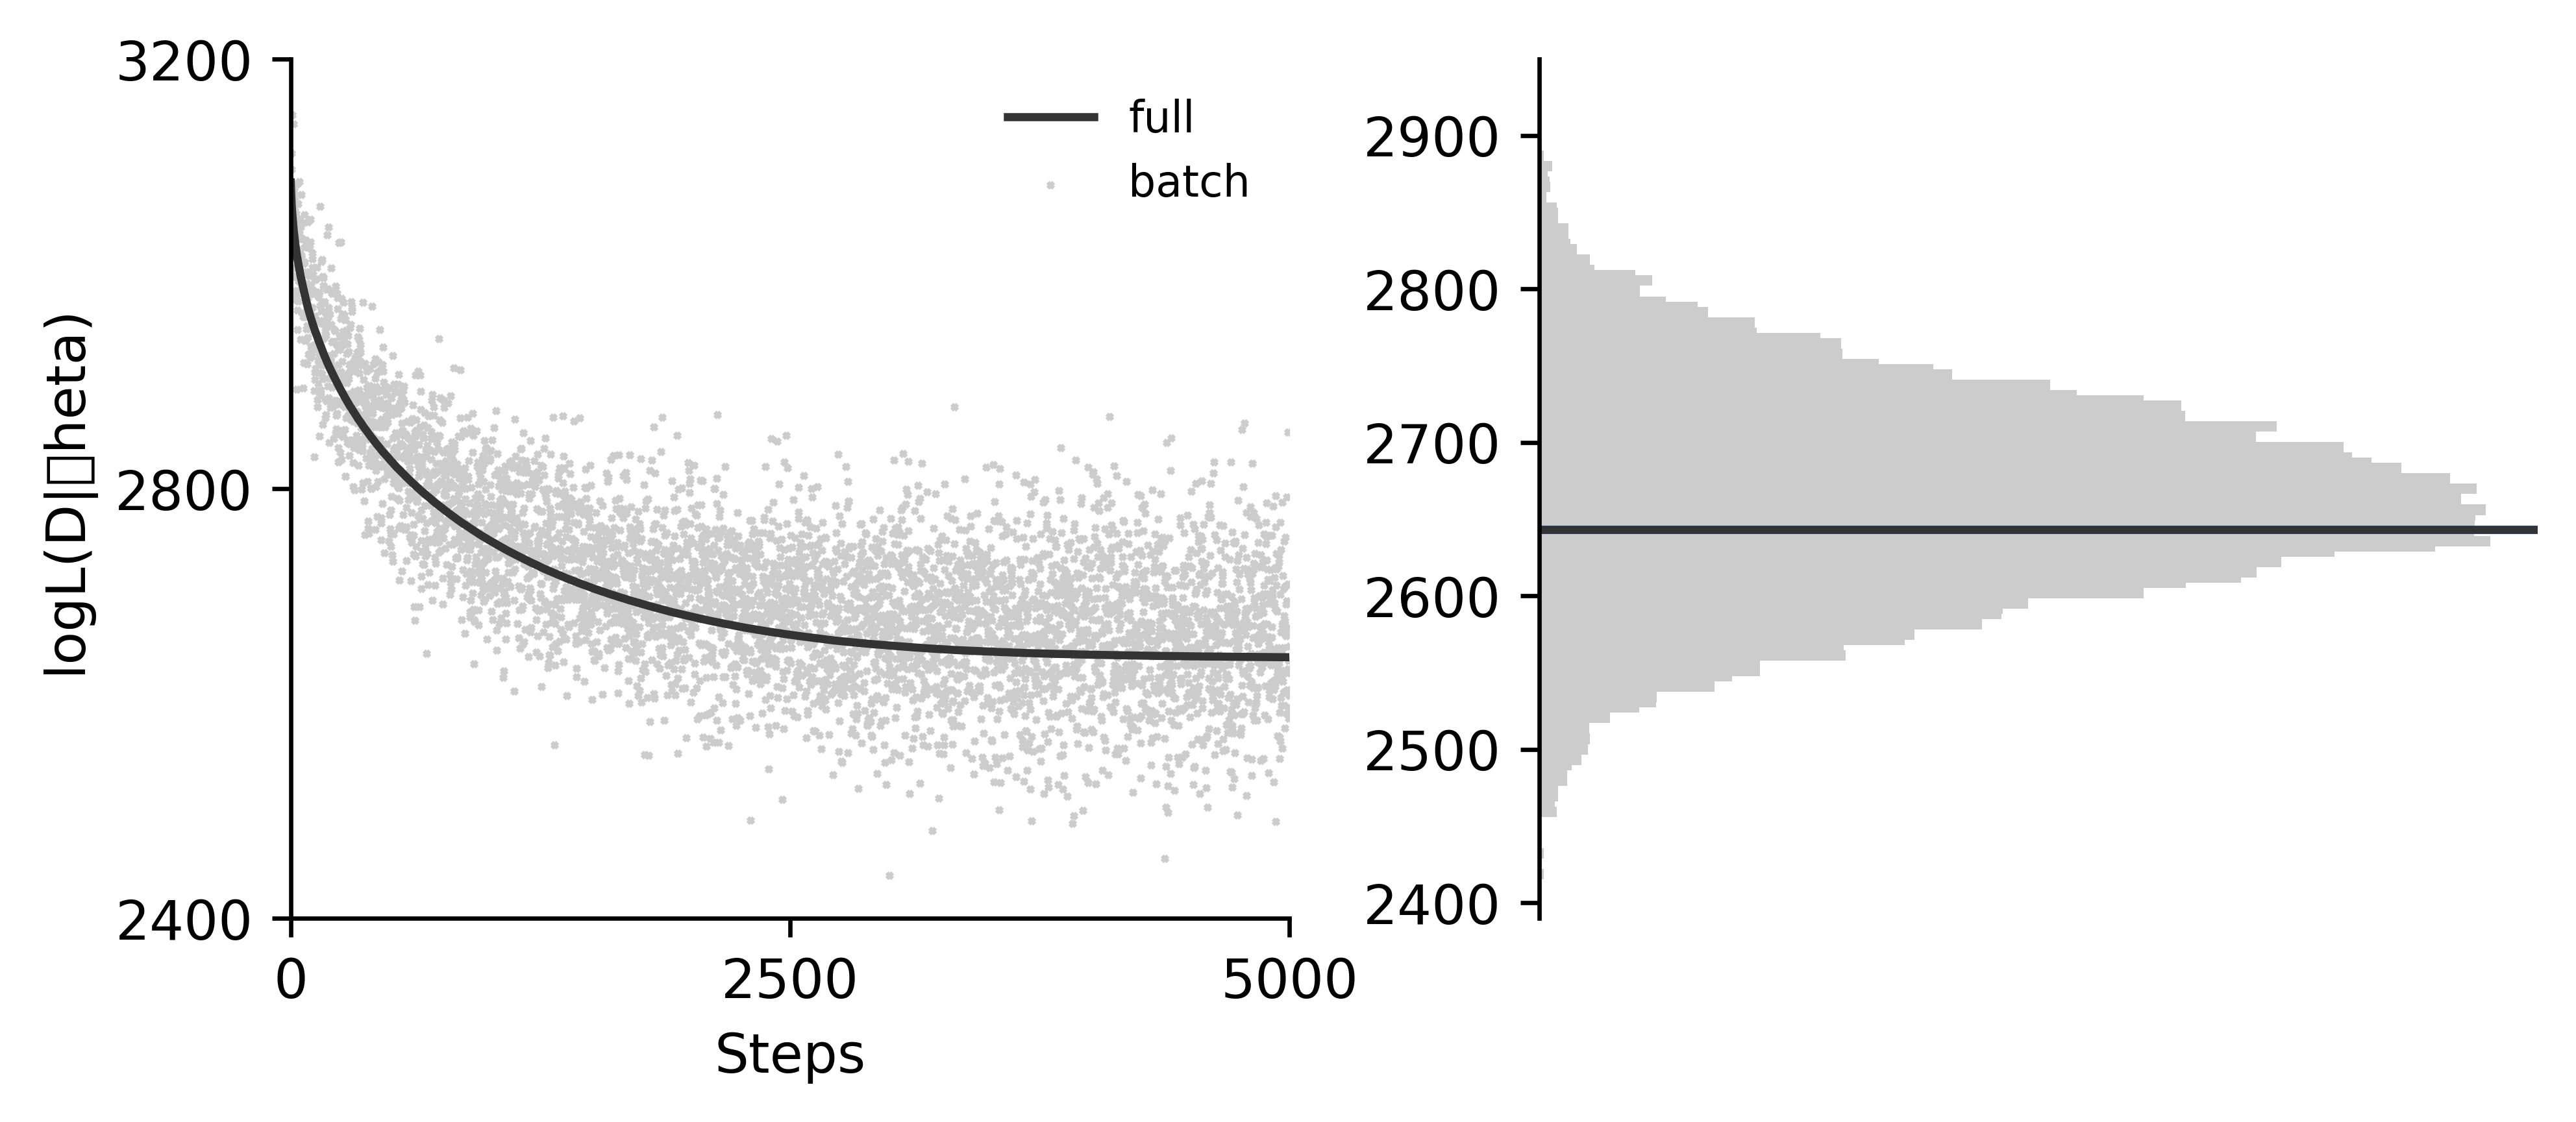

In [9]:

# Plot
# =======================================================================================================================

fig, ax = plt.subplots(1, 2, figsize=(8.27*0.90, 11.69/4), dpi=600)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)
ax[0].scatter(np.arange(5000), -np.asarray(LL_batch)[:5000], color='0.8', alpha=1, label='batch', s=0.3, marker='x')
ax[0].plot(np.arange(5000), -np.asarray(LL_full)[:5000], color='.2', label='full')
ax[1].hist(-np.asarray(m_approx), bins=75, alpha=1, color='0.8', density=True, orientation='horizontal')
ax[1].axhline(-m_est, color='#0b64e0')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('logL(D|\theta)')
ax[0].set_yticks([2400, 2800, 3200])
ax[0].set_ylim([2400, 3200])
ax[0].set_xticks([0, 2500, 5000])
ax[0].set_xlim([0, 5000])

ax[1].hist(-np.asarray(m_approx), bins=50, alpha=1, color='0.8', density=True, orientation='horizontal')
ax[1].axhline(-m_est, color='.2')
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticks([])
ax[0].legend(frameon=False, prop={'size': 8})
plt.show()
plt.close()
